In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.utils import shuffle
from plsr.analysis import *
from plsr.outliers import MonteCarloOutliers, isolation_forest
from brokenaxes import brokenaxes

In [2]:
plt.rcParams['font.family'] = 'Arial'

In [3]:
from curvefit import DatasetSpectra

2024-09-16 14:29:40.915682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 14:29:40.928320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 14:29:40.931777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from boxsers.preprocessing import rubberband_baseline_cor

In [5]:
file_path = '~/data/dataset_681.csv'
domain_path = '~/data/dataset_565_domain.csv'

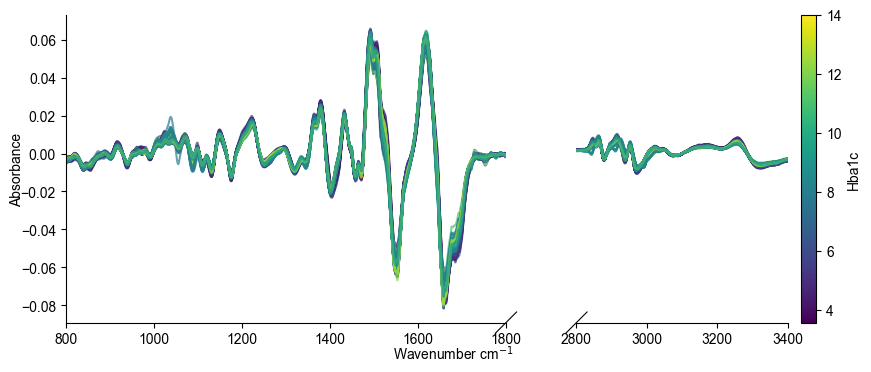

In [6]:
dataset = DatasetSpectra(file_path, domain_path)
dataset.select_max_hba1c(14)
# dataset.baseline_corr()
dataset.savgol_filter(window_length=32, polyorder=2, deriv=1)
dataset.normalization('vector')
dataset.select_region([[800, 1800], [2800, 3400]])
# dataset.select_region([800, 1800])
fig, ax = dataset.plot_spectra()

In [7]:
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# from bokeh.models import HoverTool, ColumnDataSource

# output_notebook()

# p = figure(title="FTIR Spectra", x_axis_label='Wavenumber (cm⁻¹)', y_axis_label='Absorbance')

# hover = HoverTool(tooltips=[("Sample Index", "@sample_index")])
# p.add_tools(hover)
# p.output_backend = "webgl"

# for i, spectrum in enumerate(dataset.spectra):
#     source = ColumnDataSource(data={
#         'wavenumbers': dataset.wavenumbers,
#         'absorbance': spectrum,
#         'sample_index': [i] * len(dataset.wavenumbers)
#     })
#     p.line('wavenumbers', 'absorbance', source=source, line_width=1, alpha=0.5)

# show(p)

(<Figure size 1000x400 with 4 Axes>, <brokenaxes.BrokenAxes at 0x7f93ee231ea0>)

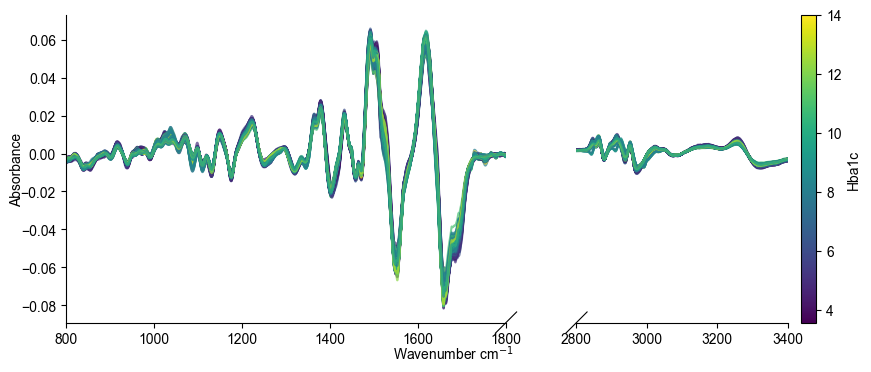

In [8]:
dataset.drop_samples([287, 636])
dataset.plot_spectra()

In [9]:
X = dataset.spectra
y = dataset.hba1c

# scaler = StandardScaler()
# y = scaler.fit_transform(y.reshape(-1, 1)).ravel()

<5.7%       250
5.7-6.5%     78
>6.5%       345
Name: count, dtype: int64


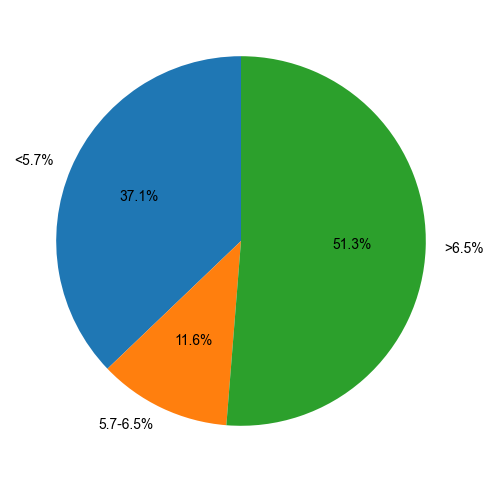

In [10]:
bins = [0, 5.7, 6.5, 14]
labels = ['<5.7%', '5.7-6.5%', '>6.5%']

binned_data = pd.cut(y, bins=bins, labels=labels, include_lowest=True)
bin_counts = binned_data.value_counts()

plt.figure(figsize=(6, 6))
plt.pie(bin_counts, labels=bin_counts.index, autopct='%1.1f%%', startangle=90)
print(bin_counts)

Text(0.5, 0, 'HbA1c%')

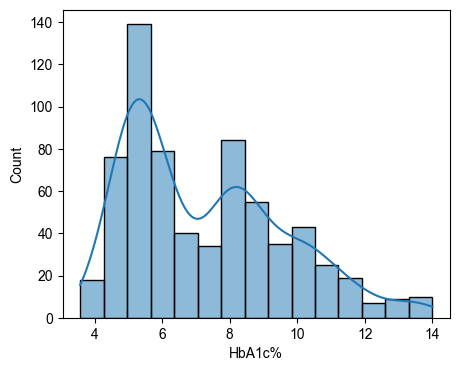

In [11]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.histplot(y, kde=True, bins=15)
ax.set_xlabel("HbA1c%")

In [12]:
discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform', subsample=None, random_state=4)
categories = discretizer.fit_transform(y.reshape(-1, 1))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=categories, random_state=34)

In [14]:
X_train, y_train = shuffle(X_train, y_train, random_state=15)

In [15]:
# fig, axs = plt.subplots(1, 2, figsize=(9, 4))
# sns.histplot(y_train, ax=axs[0], kde=True)
# sns.histplot(y_test, ax=axs[1], kde=True)

# axs[0].set_xlabel('HbA1c')
# axs[1].set_xlabel('HbA1c')

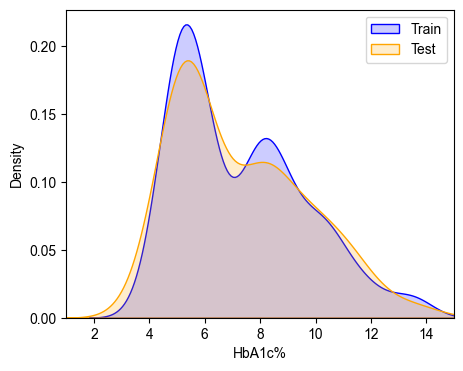

In [16]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.kdeplot(y_train, ax=ax, color='blue', fill=True, alpha=0.2, label='Train')
sns.kdeplot(y_test, ax=ax, color='orange', fill=True, alpha=0.2, label='Test')

ax.set_xlabel('HbA1c%')
ax.set_xlim([1, 15])
ax.legend()

┌───────────────────────────┐
│        FIT RESULTS        │
├───────────────────────────┤
│ RMSECV = 1.2463           │
│ R2 = 0.7169               │
│ R = 0.8473                │
│ Number of components = 11 │
└───────────────────────────┘


(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Number of components', ylabel='$R^2$'>,
         <Axes: xlabel='Number of components', ylabel='RMSECV'>],
        [<Axes: xlabel='HbA1c% measured', ylabel='HbA1c% predicted'>,
         <Axes: xlabel='HbA1c%', ylabel='Residuals'>]], dtype=object))

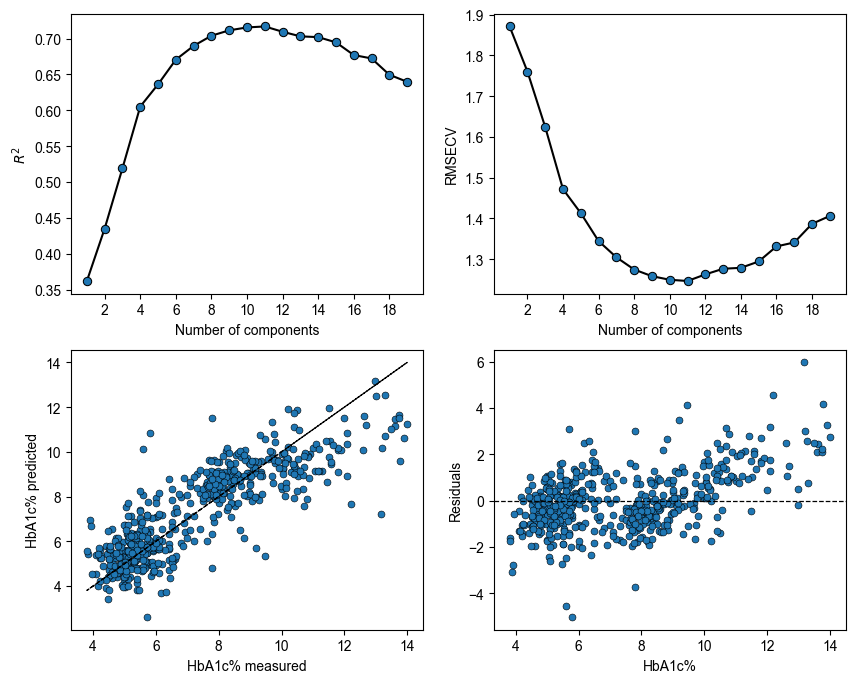

In [17]:
plot_number_components(X_train, y_train, number_range=(1, 20), cv=10)

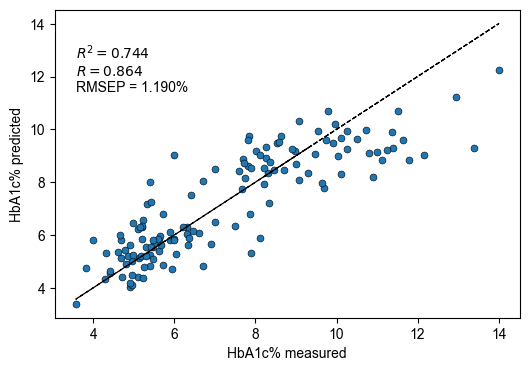

In [18]:
pls = PLSRegression(n_components=7, scale=True)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
fig, axs = plsr_r2_plot(y_test, y_pred)

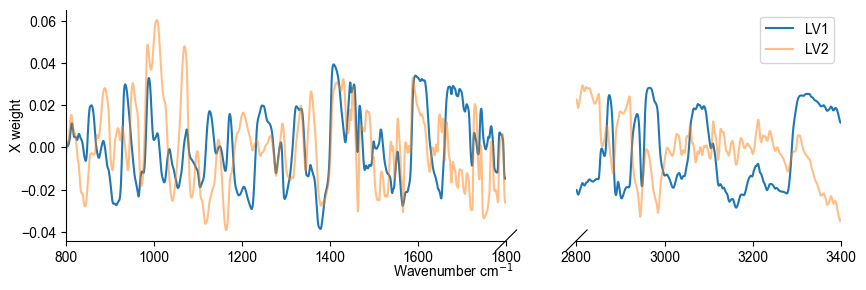

In [19]:
fig = plt.figure(figsize=(10, 3))
bax = brokenaxes(xlims=((800, 1800), (2800, 3400)), hspace=0.001)
bax.plot(dataset.wavenumbers, pls.x_weights_[:, 0], label='LV1')
bax.plot(dataset.wavenumbers, pls.x_weights_[:, 1], label='LV2', alpha=0.5)
bax.set_xlabel("Wavenumber cm$^{-1}$")
bax.set_ylabel("X weight")
bax.legend()

In [20]:
def explained_variance(model, y_train):
    r2_sum = 0
    for comp in range(0, model.n_components):
        y_pred = np.dot(model.x_scores_[:, comp].reshape(-1, 1), model.y_loadings_[:, comp].reshape(-1, 1).T) + y_train.mean(axis=0)
        r2_sum += round(r2_score(y_train, y_pred), 3)
        print('R2 for %d component: %g' %(comp + 1,round(r2_score(y_train, y_pred), 3)))
        print(f'R2 for all {comp + 1} components: {r2_sum}')
    
explained_variance(pls, y_train)

R2 for 1 component: 0.257
R2 for all 1 components: 0.257
R2 for 2 component: 0.111
R2 for all 2 components: 0.368
R2 for 3 component: 0.061
R2 for all 3 components: 0.429
R2 for 4 component: 0.032
R2 for all 4 components: 0.46099999999999997
R2 for 5 component: 0.022
R2 for all 5 components: 0.483
R2 for 6 component: 0.01
R2 for all 6 components: 0.493
R2 for 7 component: 0.02
R2 for all 7 components: 0.513
